In [26]:
from validator.InstanceCO22 import InstanceCO22
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from util import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
sns.set()
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Approach
1. assign location to closest hub 
2. determine optimal route per hub
3. Determine truck routes using hub need

In [27]:
instance = loadInstance(8)

In [28]:
def computeDistanceMatrix(instance: InstanceCO22, roundUp: bool = True) -> np.ndarray:
    # https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
        
    z = np.array([complex(l.X, l.Y) for l in instance.Locations])
    m, n = np.meshgrid(z, z)
    out = abs(m-n)
    if roundUp:
        out = np.ceil(out)
    return out


In [29]:
def assignHub(distanceMatrix: np.ndarray, hubs: list, nDepot: int = 1)-> np.ndarray:
    # Take distance matrix and assign to each point the closest hub 
    # hubs: list of indices containing place of the hubs in the distanceMatrix
    # Returns array with hub indice for each location (starting with 0). Includes depot and hubs

    hubDistanceMatrix =  distanceMatrix[hubs]
    assignedHub =  np.argmin(hubDistanceMatrix, axis=0)
    return assignedHub

In [30]:
def pointsPerHub(assignedHub: np.ndarray) -> np.ndarray:
    #List of indices per hub
    sort_idx = np.argsort(assignedHub)
    a_sorted = assignedHub[sort_idx]
    unq_first = np.concatenate(([True], a_sorted[1:] != a_sorted[:-1]))
    unq_count = np.diff(np.nonzero(unq_first)[0])
    unq_idx = np.split(sort_idx, np.cumsum(unq_count))
    return unq_idx

In [31]:
def filterRequests(instance, day = None, locationsID = None):
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res


In [32]:
def locationsWithRequest(locations, requests):
    loc_ids = [_.customerLocID for _ in requests]
    return [_ for _ in locations if _.ID in loc_ids]

In [33]:
def amountPerProduct(instance, requests):
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res

In [34]:
%%time
distanceMatrix = computeDistanceMatrix(instance,roundUp=True)
assignedHub = assignHub(distanceMatrix, hubs=[1,2])
pointsPerHub(assignedHub)

CPU times: user 1.62 ms, sys: 4.2 ms, total: 5.82 ms
Wall time: 12.3 ms


[array([ 0, 19, 18, 16, 15, 14, 12, 10, 11,  7,  4,  3,  1,  8, 22]),
 array([ 9, 21,  6, 13,  5, 17,  2, 20])]

In [35]:
def plotInstanceClusters(instance):
    nHubs = len(instance.Hubs)
    hubs = [_ for _ in range(1,nHubs+1)]
    distanceMatrix = computeDistanceMatrix(instance,roundUp=True)
    assignedHubs = assignHub(distanceMatrix, hubs=hubs)
    hubPoints = pointsPerHub(assignedHubs)
    locX = [_.X for _ in instance.Locations]
    locY = [_.Y for _ in instance.Locations]

    #plt.figure(figsize=(7,7))

    for i, hub in enumerate(hubPoints):
        hubX = [locX[i] for i in hub]
        hubY = [locY[i] for i in hub]
        plt.scatter(hubX, hubY, marker=".", label= f"Hub{i}")

    plt.scatter(locX[1:1+nHubs], locY[1:1+nHubs],marker="^", label="Hub")
    plt.scatter(locX[0], locY[0], marker=",", label="Depot")
    plt.legend(loc=(1.04,0))

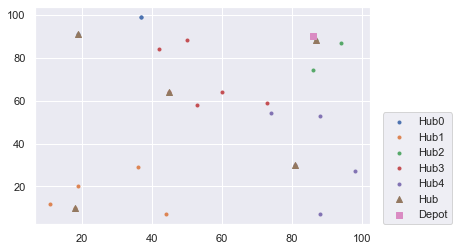

In [36]:

plotInstanceClusters(instance)

In [37]:
def toNetworkX_hubschedule(clientLocations, requests, hub=None):
    locations = clientLocations
    locations = locations + [hub]
    G = nx.DiGraph()
    for loc in locations:
        if loc.ID is hub.ID:
            G.add_node("Source")
            G.add_node("Sink")
        else:
            G.add_node(loc.ID)
            
    for req in requests:
        if req in G.nodes.keys():
            G.nodes[req.customerLocID]['demand'] = 0

    for req in requests:
        print(req.ID, " served")
        if req in G.nodes.keys():
            G.nodes[req.customerLocID]['demand'] =  G.nodes[req.customerLocID]['demand'] + sum(req.amounts)

    for l1 in locations:
        for l2 in locations:
            if l1.ID != l2.ID:
                dist = math.ceil( math.sqrt( pow(l1.X-l2.X,2) + pow(l1.Y-l2.Y,2) ))
                if l1.ID != hub.ID and l2.ID != hub.ID: 
                    G.add_edge(l1.ID, l2.ID, time = dist, cost=dist)
                elif l1.ID == hub.ID:
                    G.add_edge("Source", l2.ID, time = dist, cost=dist)
                elif l2.ID == hub.ID:
                    G.add_edge(l1.ID, "Sink", time = dist, cost=dist)
    pos = {_.ID:[_.X,_.Y] for _ in locations}
    pos['Source'] = [hub.X,hub.Y]
    pos['Sink'] = [hub.X,hub.Y]
    return G, pos

In [38]:
#locations = instance.Locations
requests = filterRequests(instance, day=1)
locations = locationsWithRequest(instance.Locations, requests)
hub = instance.Locations[1]
G, pos = toNetworkX_hubschedule(locations, requests, hub)

1  served
2  served
3  served
4  served
5  served
6  served
7  served
8  served
9  served
10  served


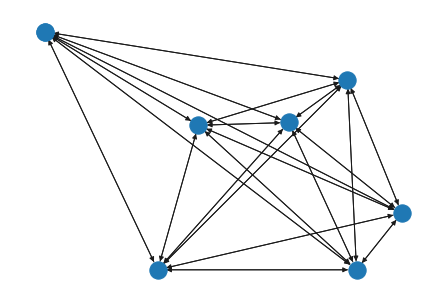

In [39]:
#pos = {_.ID:[_.X,_.Y] for _ in locations}

nx.draw(G,pos=pos)

In [40]:
prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
prob.duration = instance.VanMaxDistance
prob.solve()

INFO:vrpy.vrp:new upper bound : max num stops = 8
INFO:vrpy.vrp:Clarke & Wright solution found with value 298 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 293 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 293.0
INFO:vrpy.vrp:iteration 1, 293.0
INFO:vrpy.vrp:iteration 2, 293.0
INFO:vrpy.vrp:iteration 3, 293.0
INFO:vrpy.vrp:iteration 4, 293.0
INFO:vrpy.vrp:iteration 5, 293.0
INFO:vrpy.vrp:iteration 6, 293.0
INFO:vrpy.vrp:iteration 7, 293.0
INFO:vrpy.vrp:iteration 8, 293.0
INFO:vrpy.master_solve_pulp:total cost = 293.0


In [41]:
prob.best_routes

{1: ['Source', 23, 20, 15, 22, 18, 10, 'Sink']}

In [42]:
def plotRoute(locations, route, hub, c='red', ax=None):
    #route: ['Source', 11, 21, 20, 16, 7, 13, 19, 22, 14, 15, 'Sink']}
    for i in range(0,len(route)-1):
        p1 = route[i]
        p2 = route[i+1]
        if p1 == 'Source' or p1 == 'Sink':
            loc1 = (hub.X,hub.Y)
        else:
            loc1 = [_ for _ in locations if _.ID is p1][0]
            loc1 = (loc1.X,loc1.Y)

        if p2 == 'Source' or p2 == 'Sink':
            loc2  = (hub.X,hub.Y)
        else:
            loc2 = [_ for _ in locations if _.ID is p2][0]
            loc2 = (loc2.X,loc2.Y)
        if ax:
            ax.plot([loc1[0],loc2[0]],[loc1[1],loc2[1]], c=c)
        else:
            plt.plot([loc1[0],loc2[0]],[loc1[1],loc2[1]], c=c)

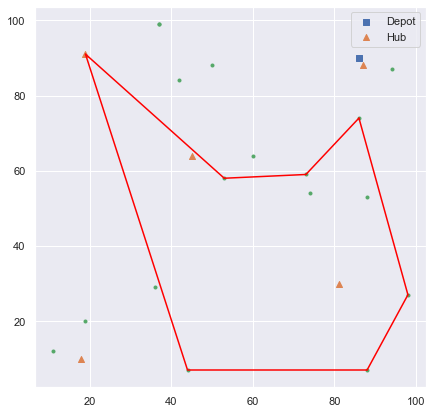

In [43]:
plotInstance(instance)
plotRoute(locations, prob.best_routes[1], hub=hub)

In [44]:
def toNetworkX_depotschedule(hubs, depot, demands):
    locations = hubs
    locations = locations + [depot]
    G = nx.DiGraph()
    for loc in locations:
        if loc.ID is depot.ID:
            G.add_node("Source")
            G.add_node("Sink")
        else:
            G.add_node(loc.ID)

    for ID, v in demands.items():
        G.nodes[ID]['demand'] = v['demand']

    for l1 in locations:
        for l2 in locations:
            if l1.ID != l2.ID:
                dist = math.ceil( math.sqrt( pow(l1.X-l2.X,2) + pow(l1.Y-l2.Y,2) ))
                if l1.ID != depot.ID and l2.ID != depot.ID: 
                    G.add_edge(l1.ID, l2.ID, time = dist, cost=dist)
                elif l1.ID == depot.ID:
                    G.add_edge("Source", l2.ID, time = dist, cost=dist)
                elif l2.ID == depot.ID:
                    G.add_edge(l1.ID, "Sink", time = dist, cost=dist)
    pos = {_.ID:[_.X,_.Y] for _ in locations}
    pos['Source'] = [depot.X,depot.Y]
    pos['Sink'] = [depot.X,depot.Y]
    return G, pos


INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 213 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 213 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 213.0
INFO:vrpy.vrp:iteration 1, 213.0
INFO:vrpy.vrp:iteration 2, 213.0
INFO:vrpy.master_solve_pulp:total cost = 213.0


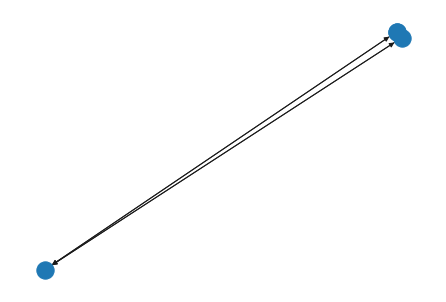

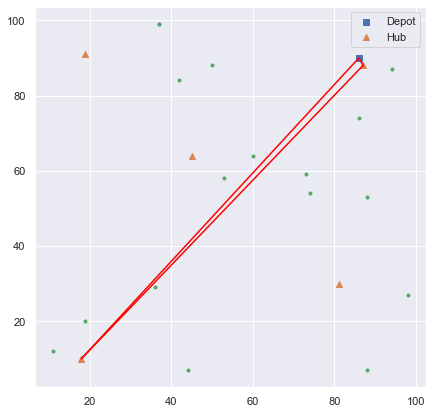

In [45]:
hubs = instance.Locations[2:4]
depot = instance.Locations[0]
demands = {3: {'demand': 4, 'routes': {1: [7, 14, 7]}},
           4: {'demand': 5, 'routes': {1: [8, 21, 8]}}}
G, pos = toNetworkX_depotschedule(hubs, depot, demands)
nx.draw(G, pos=pos)
prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
prob.duration = instance.TruckMaxDistance
prob.solve()
plotInstance(instance)
plotRoute(hubs, prob.best_routes[1], hub=depot)

In [46]:
def sol1(instance):
    #hub routes
    distanceMatrix = computeDistanceMatrix(instance,roundUp=True)
    nHubs = len(instance.Hubs)
    hubs = [_ for _ in range(1,nHubs+1)]
    assignedHub = assignHub(distanceMatrix, hubs=hubs)
    hubs = pointsPerHub(assignedHub)

    #Hub schedule
    hubRoutes = {}
    for day in range(1,instance.Days+1):
        print("---------------------")
        dayRoutes = {}
        for i, hub_locations_ID in enumerate(hubs):
            hub_ID = i + 2
            requests = filterRequests(instance, day=day, locationsID = list(hub_locations_ID+1))
            if len(requests) == 0:
                continue
            locations = locationsWithRequest(instance.Locations, requests)
            print(day)
            print(len(requests))
            print(len(locations))
            G, _ = toNetworkX_hubschedule(clientLocations = locations, requests=requests, hub=instance.Locations[i+1]) #add 1 because 1 depot
            prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
            prob.duration = instance.VanMaxDistance
            prob.solve()
            best_routes = prob.best_routes
            best_routes = {'routes':{id:listReplace(best_routes[id], ["Source","Sink"], hub_ID) for id in best_routes.keys()}}
            best_routes['demand'] = sum([sum(req.amounts) for req in requests])
            best_routes['demandPerProduct'] = amountPerProduct(instance, requests)
            dayRoutes[hub_ID] = best_routes
        hubRoutes[day] = dayRoutes

    #depot schedule
    depotRoutes = {}
    depotLocation = instance.Locations[0]
    depotID = 1
    for day in range(1,instance.Days+1):
        hubsUsed = hubRoutes[day]
        hubLocations = [instance.Locations[_-1] for _ in hubsUsed.keys()]
        if len(hubLocations) > 0:
            G, _ = toNetworkX_depotschedule(hubLocations, depotLocation, hubsUsed)
            prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
            prob.duration = instance.TruckMaxDistance
            prob.solve()
            depotRoutes[day] = {id:listReplace(prob.best_routes[id], ["Source","Sink"], depotID) for id in prob.best_routes.keys()}
        else:
            depotRoutes[day] = {}

   
    return {'hubRoutes':hubRoutes, 'depotRoutes':depotRoutes}

In [47]:
%%capture
instance=loadInstance(15)
res = sol1(instance);

INFO:vrpy.vrp:new upper bound : max num stops = 7
INFO:vrpy.vrp:Clarke & Wright solution found with value 171 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 184 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 171.0
INFO:vrpy.vrp:iteration 1, 171.0
INFO:vrpy.vrp:iteration 2, 171.0
INFO:vrpy.vrp:iteration 3, 171.0
INFO:vrpy.vrp:iteration 4, 171.0
INFO:vrpy.vrp:iteration 5, 171.0
INFO:vrpy.vrp:iteration 6, 171.0
INFO:vrpy.master_solve_pulp:total cost = 171.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 46 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 46 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 46.0
INFO:vrpy.vrp:iteration 1, 46.0
INFO:vrpy.vrp:iteration 2, 46.0
INFO:vrpy.master_solve_pulp:total cost = 46.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 33 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 33 and 1 vehicles
INFO:vrpy.v

In [48]:
print(pprint.pformat(res['depotRoutes']))

{1: {1: [1, 2, 4, 6, 3, 1]},
 2: {1: [1, 2, 4, 6, 3, 1]},
 3: {1: [1, 6, 2, 4, 5, 3, 1]},
 4: {1: [1, 2, 4, 6, 3, 1]},
 5: {1: [1, 2, 1], 2: [1, 4, 5, 1]},
 6: {1: [1, 2, 4, 6, 1], 2: [1, 3, 1]},
 7: {1: [1, 2, 4, 6, 1]},
 8: {1: [1, 3, 5, 6, 2, 1]},
 9: {1: [1, 2, 4, 6, 3, 1]},
 10: {1: [1, 2, 6, 3, 1]},
 11: {1: [1, 2, 4, 6, 3, 1]},
 12: {1: [1, 2, 4, 6, 3, 1]},
 13: {1: [1, 3, 6, 1], 2: [1, 2, 1]},
 14: {1: [1, 2, 4, 5, 6, 1]},
 15: {1: [1, 2, 4, 6, 3, 1]},
 16: {1: [1, 2, 1]},
 17: {1: [1, 6, 4, 5, 3, 1], 2: [1, 2, 1]},
 18: {1: [1, 3, 4, 6, 1]},
 19: {1: [1, 6, 2, 4, 5, 3, 1]},
 20: {1: [1, 4, 5, 1]}}


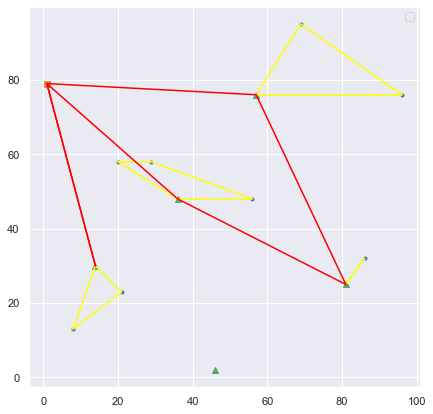

In [49]:
#plotInstance(instance)
day = 6
locs = locationsWithRequest(instance.Locations, filterRequests(instance, day=day))
plotLocations(locs)
#plotInstanceClusters(instance)
locX = [_.X for _ in instance.Locations]
locY = [_.Y for _ in instance.Locations]
nHubs = len(instance.Hubs)
plt.scatter(locX[0], locY[0], marker=",", label="Depot")
plt.scatter(locX[1:1+nHubs], locY[1:1+nHubs],marker="^", label="Hub")

for hub in  res['hubRoutes'][day]:
    for route in res['hubRoutes'][day][hub]['routes']:
        plotRoute(instance.Locations, res['hubRoutes'][day][hub]['routes'][route], hub=None,c = 'yellow')

for route in res['depotRoutes'][day]:
        plotRoute(instance.Locations, res['depotRoutes'][day][route], hub=None, c='red')


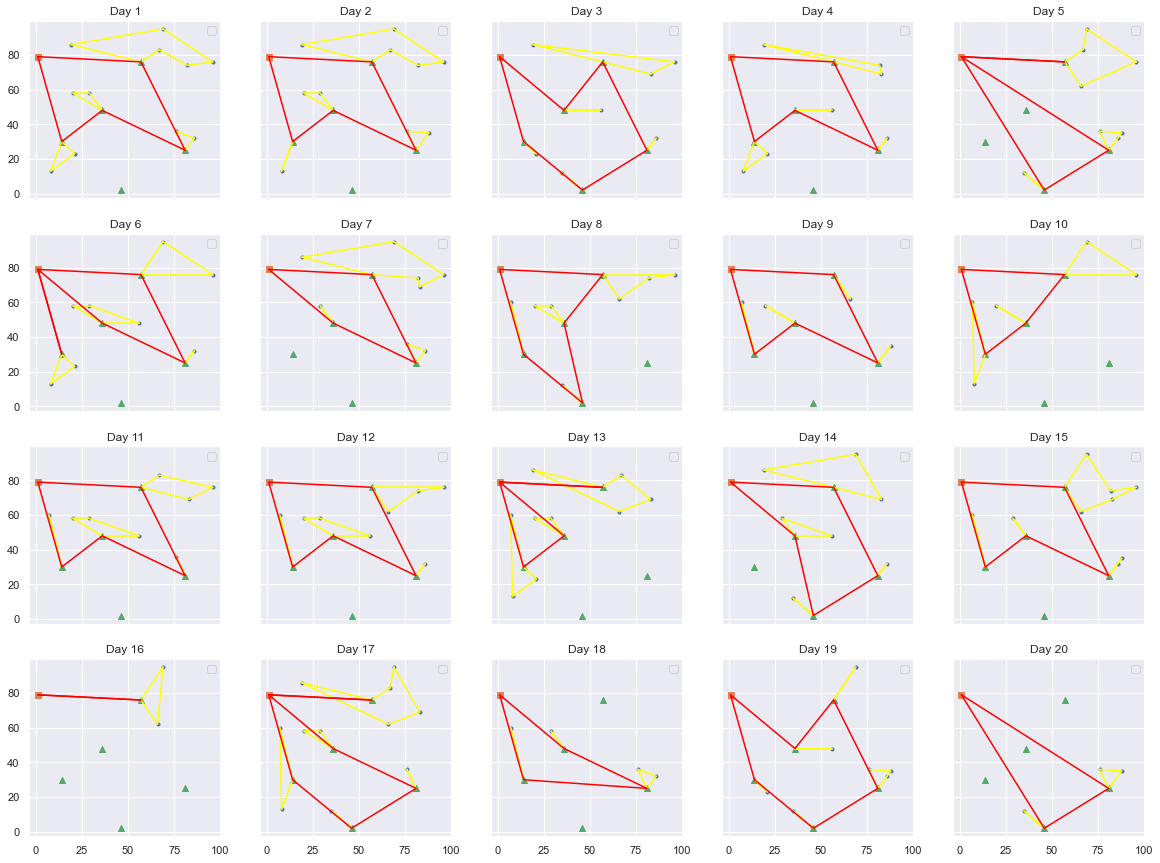

In [50]:
#%%capture
nCol = 5
nDays = instance.Days
fig, axs = plt.subplots(ncols= nCol, nrows = int(math.ceil(nDays/nCol)), figsize=(20,15), sharex=True, sharey=True)
for i in range(1, nDays+1):
    day = i
    row = math.ceil(i/nCol)-1
    col = (i-1)%nCol
    locs = locationsWithRequest(instance.Locations, filterRequests(instance, day=day))
    plotLocations(locs, ax = axs[row][col]);
    #plotInstanceClusters(instance)
    locX = [_.X for _ in instance.Locations]
    locY = [_.Y for _ in instance.Locations]
    nHubs = len(instance.Hubs)
    axs[row][col].scatter(locX[0], locY[0], marker=",", label="Depot")
    axs[row][col].scatter(locX[1:1+nHubs], locY[1:1+nHubs],marker="^", label="Hub")
    axs[row][col].set_title(f"Day {i}")
    for hub in  res['hubRoutes'][day]:
        for route in res['hubRoutes'][day][hub]['routes']:
            plotRoute(instance.Locations, res['hubRoutes'][day][hub]['routes'][route], hub=None,c = 'yellow', ax = axs[row][col]);

    for route in res['depotRoutes'][day]:
            plotRoute(instance.Locations, res['depotRoutes'][day][route], hub=None, c='red', ax = axs[row][col]);

In [51]:
def requestsIdForRoute(route, instance, day):
    #Reverse engineer request ids for given route and day
    route = route[1:-1] #trim hub
    res = []
    requests = filterRequests(instance, day=day)
    for i, locID in enumerate(route):
        for req in requests:
            if req.customerLocID == locID:
                res.append(req.ID)
    return res

In [52]:
def toStr(res, instance):
    resultString = "DATASET = CO2022_11 \n \n"
    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"
        nTrucks = len(res['depotRoutes'][day])
        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"

        truckString = ""
        for i, truckRoute in res['depotRoutes'][day].items():
            truckString += f"{i} "
            for hub in truckRoute[1:-1]:
                amountPerProduct = res['hubRoutes'][day][hub]['demandPerProduct']
                truckString += f"H{hub-1} {','.join([str(_) for _ in amountPerProduct])} "
            truckString += "\n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hub in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hub]['routes'].items():
                i+=1
                reqIds = requestsIdForRoute(route, instance, day)
                vanString += f"{i} H{hub-1} {','.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hub]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"  
        resultString += vanString + "\n"
    return resultString
    